# Comparative Case Study: ARIMA + GARCH and LSTM for Meta (META) Stock Price Prediction

## 1. Introduction

### 1.1. Background and Motivation

Time series forecasting in quantitative finance must contend with two fundamental challenges: capturing the mean behavior of asset prices and modeling their volatility dynamics. Traditional statistical models like ARIMA (AutoRegressive Integrated Moving Average) excel at modeling the conditional mean of time series but often fall short in capturing the time-varying volatility and clustering effects characteristic of financial returns—phenomena well-described by the GARCH (Generalized Autoregressive Conditional Heteroskedasticity) framework.

The ARIMA+GARCH hybrid model represents a powerful econometric approach that decomposes the forecasting problem: ARIMA models the predictable component in returns (conditional mean), while GARCH captures the volatility clustering (conditional variance). This combination has proven robust for financial time series where volatility persistence is a key feature.

However, the rise of deep learning introduces compelling alternatives. Long Short-Term Memory (LSTM) networks can simultaneously learn both mean and volatility patterns without explicit decomposition, potentially capturing complex non-linear dependencies that traditional models might miss. Their ability to model long-range dependencies and adapt to changing market regimes makes them theoretically attractive for financial forecasting.

This context presents a critical empirical question: In forecasting high-frequency financial instruments, does the hybrid econometric approach of ARIMA+GARCH maintain its established superiority, or do sophisticated deep learning models like LSTM provide a decisive advantage through their holistic, data-driven approach? This study addresses this question through a rigorous comparative analysis.

### 1.2. Objective

This study aims to provide a comprehensive comparison between the hybrid ARIMA+GARCH econometric model and the LSTM neural network for forecasting the daily closing price of Meta Platforms Inc. (META). The analysis spans from **January 1, 2023, to November 1, 2025**, capturing diverse market conditions including post-pandemic recovery and recent economic volatility. The primary objectives are:

*   To empirically evaluate and compare the one-step-ahead forecasting performance of ARIMA+GARCH and LSTM models on META closing prices.
*   To assess model performance on data using **Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and Mean Absolute Percentage Error (MAPE)**.
*   To compare not only point forecasts but also uncertainty quantification through confidence intervals from GARCH volatility estimates.
*   To discuss the practical trade-offs between interpretable econometric modeling and flexible deep learning approaches in financial applications.

### 1.3. Research Questions

- How does the ARIMA+GARCH model's explicit volatility modeling compare to the LSTM's implicit pattern recognition?
- How does each model's performance differ in generalizing to unseen data (out-of-sample)?
- What are the practical implications of choosing one model over the other in terms of complexity, computational cost, and interpretability?

## 2. Library Imports

In [1]:
# Environment configuration
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import warnings
# 1. DATA MANIPULATION AND ANALYSIS
import pandas as pd  
import numpy as np   

# 2. DATA VISUALIZATION
import matplotlib.pyplot as plt 
import seaborn as sns            

# 3. FINANCIAL DATA ACQUISITION
import yfinance as yf  # Stock market data download

# 4. MACHINE LEARNING AND DEEP LEARNING
from tensorflow import keras                    
from sklearn.preprocessing import MinMaxScaler 

# 5. TIME SERIES ANALYSIS AND MODELING
from statsmodels.tsa.arima.model import ARIMA  
from pmdarima import auto_arima 
from statsmodels.tsa.stattools import adfuller, kpss            
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from arch import arch_model  
from statsmodels.stats.diagnostic import het_arch
from scipy.stats import norm, shapiro, jarque_bera, probplot
# from arch.univariate import GARCH, Normal, StudentsT  

# 6. MODEL EVALUATION METRICS
from sklearn.metrics import (
    mean_absolute_error,       
    mean_absolute_percentage_error,   
    mean_squared_error          
)

## 3. Data Acquisition and Preparation

### 3.1. Data Source and Description

*   Use the `yfinance` library to fetch META stock data.
    *   **Ticker:** `META`
    *   **Period:** `start="2023-01-01"`, `end="2025-11-01"`.
    *   **Target Variable:** `Close` price.

In [2]:
meta = yf.Ticker("META")
data = meta.history(start="2023-01-01", end="2025-11-01")
data = data['Close']

### 3.2. Data Loading and Initial Exploration

Date
2023-01-03 00:00:00-05:00    123.874695
2023-01-04 00:00:00-05:00    126.486450
2023-01-05 00:00:00-05:00    126.059433
2023-01-06 00:00:00-05:00    129.118057
2023-01-09 00:00:00-05:00    128.571884
Name: Close, dtype: float64
<class 'pandas.core.series.Series'>
DatetimeIndex: 711 entries, 2023-01-03 00:00:00-05:00 to 2025-10-31 00:00:00-04:00
Series name: Close
Non-Null Count  Dtype  
--------------  -----  
711 non-null    float64
dtypes: float64(1)
memory usage: 11.1 KB
None
Close prices plot over time plot:


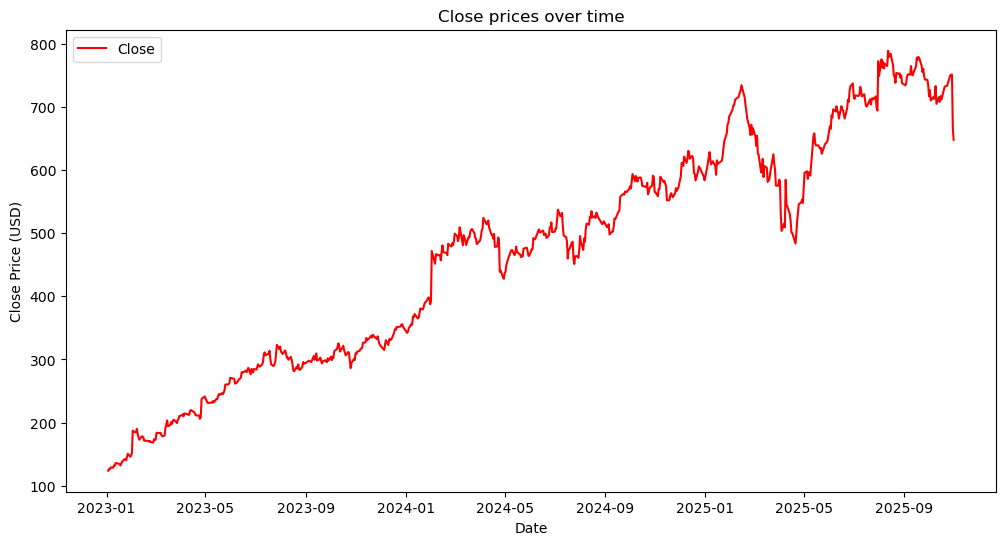

In [3]:
# Initial data exploration
print(data.head())
print(data.info())
data.isna().count()
# Close prices plot over time
print("Close prices plot over time plot:")
plt.figure(figsize = (12,6))
plt.plot(data.index, data, label="Close", color="red")
plt.xlabel("Date") 
plt.ylabel("Close Price (USD)")
plt.title("Close prices over time")
plt.legend()
plt.show()

as we can see here, the time series has a strong **upward trend** so it is **non-stationary**.

To confirm that, an Augmented Dickey-Fuller (ADF) test is performed

In [4]:
adf_test = adfuller(data)
print(f'p-value: {adf_test[1]}')

p-value: 0.47002869146374504


This result shows a large p-value, meaning that the test fails to reject the null hypothesis, so the ADF test also confirm the time series is non-stationary

### 3.3. Data Preprocessing

In [5]:
# Perform an 80-20 chronological split. The first 80% of the data is for training, the last 20% is for testing
training_data_len = int(np.ceil(len(data) * 0.80)) # 80% of training

# Split the data
training_data_ARIMA_GARCH = data[:training_data_len] 
testing_data_ARIMA_GARCH = data[training_data_len:] 
training_data_LSTM = data[:training_data_len] 
testing_data_LSTM = data[training_data_len:] 

# Differencing (for ARIMA) - keep this for ARIMA+GARCH
training_data_ARIMA_diff = training_data_ARIMA_GARCH.diff().dropna()

# For GARCH: calculate returns for volatility modeling
train_log_returns = np.log(training_data_ARIMA_GARCH / training_data_ARIMA_GARCH.shift(1)).dropna()

# Reshape to 2D array (required by MinMaxScaler) and scale only training data for LSTM
training_data_LSTM_2d = training_data_LSTM.values.reshape(-1, 1)

# Scale the training data (for LSTM) - test data will be scaled later during prediction
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(training_data_LSTM_2d)

## 4. Methodology & Model Implementation

### 4.1. ARIMA+GARCH Modeling

#### 4.1.1. Model Identification and Stationarity:

First we are going to plot the log differentiated training data for initial inspection

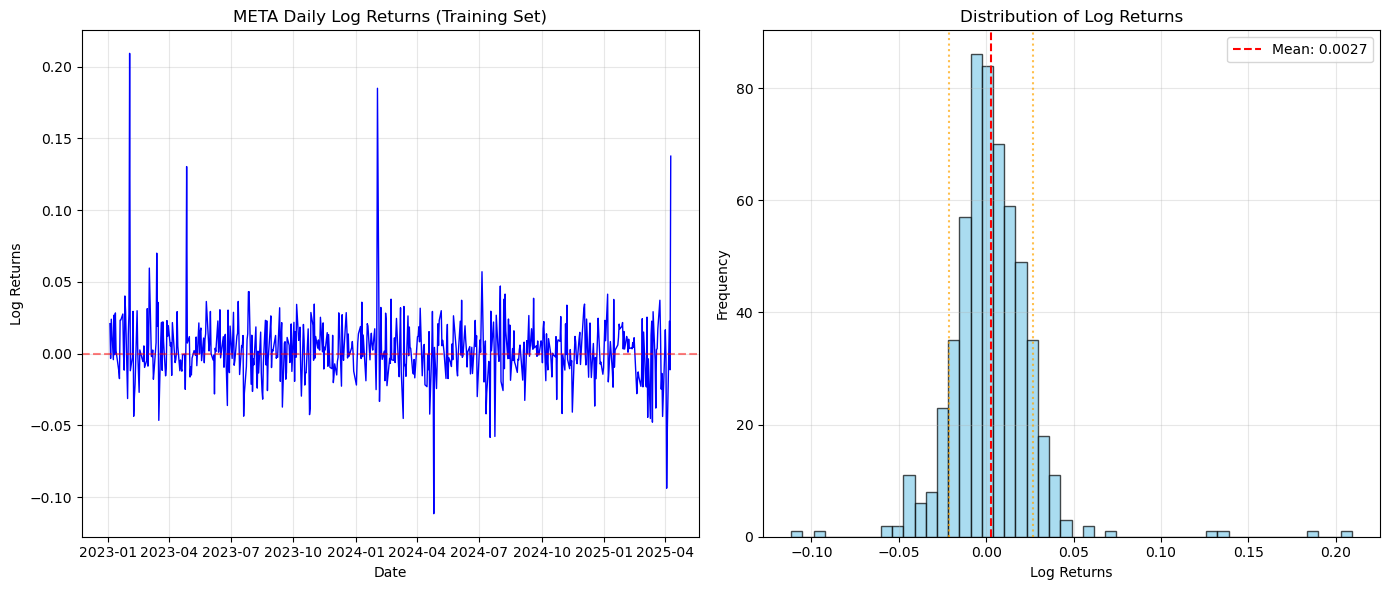

In [6]:
# Visualize log returns
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(train_log_returns.index, train_log_returns.values, color='blue', linewidth=1)
plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)
plt.title('META Daily Log Returns (Training Set)')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(train_log_returns.values, bins=50, edgecolor='black', alpha=0.7, color='skyblue')
plt.title('Distribution of Log Returns')
plt.xlabel('Log Returns')
plt.ylabel('Frequency')
plt.axvline(x=train_log_returns.mean(), color='red', linestyle='--', label=f'Mean: {train_log_returns.mean():.4f}')
plt.axvline(x=train_log_returns.mean() + train_log_returns.std(), color='orange', linestyle=':', alpha=0.7)
plt.axvline(x=train_log_returns.mean() - train_log_returns.std(), color='orange', linestyle=':', alpha=0.7)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Visual inspection of the log-differenced time series indicates the successful removal of the underlying trend, with the data now fluctuating around a stable mean, a key characteristic of stationarity.

To statistically validate this observation, we first apply the Augmented Dickey-Fuller (ADF) test:

In [7]:
adf_result = adfuller(train_log_returns)
print(f"ADF Test on Log Returns:")
print(f"  Test Statistic: {adf_result[0]:.6f}")
print(f"  p-value: {adf_result[1]:.6f}")

ADF Test on Log Returns:
  Test Statistic: -23.449590
  p-value: 0.000000


The ADF test yields a p-value approaching zero, providing strong evidence to reject the null hypothesis of a unit root at the 1% significance level. This initial result suggests the series is stationary.

To confirm this finding, we employ the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test, whose null hypothesis is the opposite that the series is stationary:

In [8]:
kpss_result = kpss(train_log_returns, regression='c', nlags=1)
print(f"\nKPSS Test on Log Returns:")
print(f"  Test Statistic: {kpss_result[0]:.6f}")
print(f"  p-value: {kpss_result[1]:.4f}")


KPSS Test on Log Returns:
  Test Statistic: 0.424572
  p-value: 0.0666


The KPSS test returns a p-value of 0.0666 (using lag=1, justified by the ACF showing no autocorrelation), which exceeds the conventional 5% significance level. This failure to reject the null hypothesis provides confirmation of stationarity, aligning with the strong evidence from the ADF test.

Both statistical tests converge on the same conclusion. The ADF test strongly rejects non-stationarity, while the KPSS test fails to reject stationarity. This dual confirmation establishes that log-differencing has successfully rendered the time series stationary. Consequently, we set the integration order parameter **d = 0** in the ARIMA model specification and work with log returns data.


4. AUTOCORRELATION ANALYSIS (ACF/PACF)
--------------------------------------------------


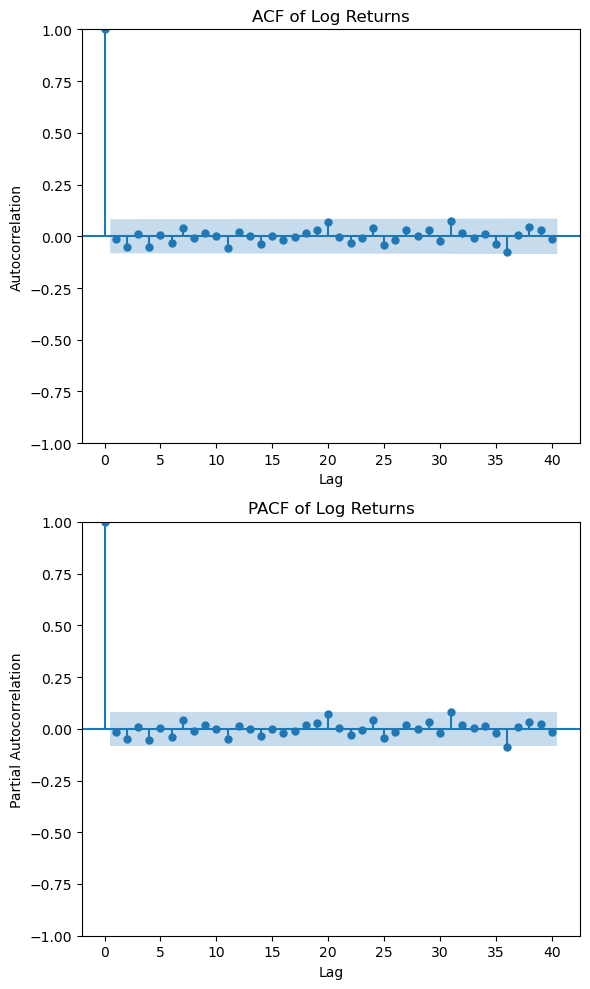

In [9]:
# ACF and PACF plots for log returns
print("\n4. AUTOCORRELATION ANALYSIS (ACF/PACF)")
print("-" * 50)

fig, axes = plt.subplots(2, 1, figsize=(6, 10))

# ACF of returns
plot_acf(train_log_returns, lags=40, ax=axes[0], title='ACF of Log Returns')
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('Autocorrelation')

# PACF of returns
plot_pacf(train_log_returns, lags=40, ax=axes[1], title='PACF of Log Returns')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('Partial Autocorrelation')

plt.tight_layout()
plt.show()

The ACF and PACF plots of log returns reveal no significant autocorrelation at any lag beyond lag 0. This pattern indicates that the returns exhibit no autocorrelation structure, consistent with white noise behavior. The auto-ARIMA algorithm subsequently confirmed this by selecting **ARIMA(0,0,0)** as the optimal model for log returns.

#### 4.1.2. Model Diagnostics:

In [10]:
print("\n" + "="*70)
print("AUTO-ARIMA MODEL SELECTION")
print("="*70)

# Scale returns for better numerical stability (common practice in GARCH modeling)
scaling_factor = 100
train_log_returns_scaled = train_log_returns * scaling_factor

print("Performing auto-ARIMA search on scaled log returns...")
print("Searching for optimal ARIMA(p,d,q) parameters...")
print("-" * 50)

# Perform auto-ARIMA search with comprehensive settings
auto_model = auto_arima(
    train_log_returns_scaled,
    start_p=0,      # Minimum AR order
    start_q=0,      # Minimum MA order
    max_p=5,        # Maximum AR order
    max_q=5,        # Maximum MA order
    d=None,         # Let auto-arima determine differencing
    test='adf',     # Use ADF test for stationarity
    trace=True,     # Show progress
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,  # Use stepwise algorithm for efficiency
    information_criterion='aic',  # Use AIC for model selection
)

# Get the best ARIMA order
best_order = auto_model.order
print(f"\nBest ARIMA order selected: ARIMA{best_order}")
print(f"Selected model AIC: {auto_model.aic():.2f}")

# Show model summary
print("\nAuto-ARIMA Model Summary:")
print("-" * 50)
print(auto_model.summary())



AUTO-ARIMA MODEL SELECTION
Performing auto-ARIMA search on scaled log returns...
Searching for optimal ARIMA(p,d,q) parameters...
--------------------------------------------------
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2614.067, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2615.955, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2615.942, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2619.330, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2616.731, Time=0.48 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.690 seconds

Best ARIMA order selected: ARIMA(0, 0, 0)
Selected model AIC: 2614.07

Auto-ARIMA Model Summary:
--------------------------------------------------
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  568
Model:                        SARIMAX   Log Likelihood       

The **AUTO-ARIMA MODEL SELECTION** confirms the random walk nature of the stock price, providing a robust baseline. However, this presents a fundamental forecasting challenge: modeling white noise is inherently difficult, as there are no meaningful autoregressive or moving average patterns in the ACF/PACF plots to capture. This simple yet valid model sets a critical benchmark for evaluating whether LSTM can extract any predictive signal from what appears to be random movements.

#### 4.1.3. Model Training:

In [11]:
print("\n" + "="*70)
print("ARIMA+GARCH MODEL TRAINING")
print("="*70)

print(f"\n1. TRAINING ARIMA{best_order} ON LOG RETURNS")
print("-" * 50)

# Train ARIMA model with auto-selected order (on unscaled returns)
print(f"Training ARIMA{best_order} on log returns...")
arima_model = ARIMA(train_log_returns, order=best_order)
arima_fit = arima_model.fit()

print("\nARIMA Model Diagnostics:")
print("-" * 50)
print(f"ARIMA Model: ARIMA{best_order}")
print(f"Log Likelihood: {arima_fit.llf:.2f}")
print(f"AIC: {arima_fit.aic:.2f}")
print(f"BIC: {arima_fit.bic:.2f}")

# Extract residuals for GARCH modeling
arima_residuals = arima_fit.resid
print(f"\nResidual Statistics:")
print(f"  Mean: {arima_residuals.mean():.6f}")
print(f"  Std Dev: {arima_residuals.std():.6f}")
print(f"  Skewness: {arima_residuals.skew():.4f}")
print(f"  Kurtosis: {arima_residuals.kurtosis():.4f}")

# Scale residuals for GARCH (improves numerical stability)
arima_residuals_scaled = arima_residuals * scaling_factor

print("\n2. TRAINING GARCH(1,1) MODEL")
print("-" * 50)
print("Training GARCH(1,1) on scaled ARIMA residuals...")

# Fit GARCH(1,1) model
garch_model = arch_model(
    arima_residuals_scaled,
    vol='Garch',
    p=1,  # ARCH order
    q=1,  # GARCH order
    dist='normal'  # Normal distribution
)
garch_fit = garch_model.fit(disp='off', show_warning=False)

print("\nGARCH Model Summary:")
print("-" * 50)
print(f"GARCH Model: GARCH(1,1)")
print(f"Log Likelihood: {garch_fit.loglikelihood:.2f}")
print(f"AIC: {garch_fit.aic:.2f}")
print(f"BIC: {garch_fit.bic:.2f}")



ARIMA+GARCH MODEL TRAINING

1. TRAINING ARIMA(0, 0, 0) ON LOG RETURNS
--------------------------------------------------
Training ARIMA(0, 0, 0) on log returns...

ARIMA Model Diagnostics:
--------------------------------------------------
ARIMA Model: ARIMA(0, 0, 0)
Log Likelihood: 1310.70
AIC: -2617.41
BIC: -2608.72

Residual Statistics:
  Mean: 0.000005
  Std Dev: 0.024098
  Skewness: 2.0332
  Kurtosis: 18.2465

2. TRAINING GARCH(1,1) MODEL
--------------------------------------------------
Training GARCH(1,1) on scaled ARIMA residuals...

GARCH Model Summary:
--------------------------------------------------
GARCH Model: GARCH(1,1)
Log Likelihood: -1293.71
AIC: 2595.42
BIC: 2612.79


/home/yass/.conda/envs/project_ML/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/yass/.conda/envs/project_ML/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/yass/.conda/envs/project_ML/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


The ARIMA(0,0,0) model confirms that META log returns exhibit characteristics consistent with white noise, aligning with the efficient market hypothesis. The GARCH(1,1) model, while showing some persistence (α+β < 1), operates on data with limited volatility clustering as indicated by earlier diagnostics. This combination provides a theoretically sound econometric baseline for comparison with the LSTM model.

### 4.2. LSTM Modeling

#### 4.2.1. Data Windowing (Sequence Creation):

In [12]:
# SLICING WINDOW PART:
X_train, y_train = [], []

# Create slicing window for our stock (60 days)
for i in range(60, len(training_data_LSTM)):
    # Get the past 60 days as features (X)
    X_train.append(scaled_data[i - 60:i, 0]) 
    # Get the next day as target (y)
    y_train.append(scaled_data[i, 0])  

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (509, 60, 1)
y_train shape: (509,)


#### 4.2.2. Model Architecture and training:

**LSTM Model Architecture:**

*   **Type:** Sequential Deep Learning Model
*   **Input:** 3D tensor with shape `(batch_size, timesteps, 1)`
*   **Layer 1:** LSTM with 64 units, `return_sequences=True`
*   **Layer 2:** LSTM with 64 units, `return_sequences=False`
*   **Layer 3:** Dense (Fully Connected) layer with 128 units and ReLU activation
*   **Layer 4:** Dropout layer with a 20% rate for regularization
*   **Output Layer:** Dense layer with 1 unit for regression forecasting
*   **Optimizer:** Adam
*   **Loss Function:** Mean Absolute Error (MAE)
*   **Evaluation Metric:** Root Mean Squared Error (RMSE)
*   **Training:** 30 epochs with a batch size of 32

In [13]:
# build the model
LSTM_model = keras.models.Sequential()

# First Layer
LSTM_model.add(keras.layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1],1)))

# Second Layer
LSTM_model.add(keras.layers.LSTM(64, return_sequences=False))
                            
# 3rd Layer (Dense)
LSTM_model.add(keras.layers.Dense(128, activation="relu"))

# 4th Layer (Dropout)
LSTM_model.add(keras.layers.Dropout(0.2))

# Final output layer
LSTM_model.add(keras.layers.Dense(1))

LSTM_model.summary()
LSTM_model.compile(
    optimizer="adam",
    loss="mae",
    metrics=[keras.metrics.RootMeanSquaredError()]
)

training = LSTM_model.fit(X_train, y_train, epochs=30, batch_size=32)


/home/yass/.conda/envs/project_ML/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,369 (228.00 KB)

 Trainable params: 58,369 (228.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.1927 - root_mean_squared_error: 0.2594
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.0755 - root_mean_squared_error: 0.0970
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0547 - root_mean_squared_error: 0.0731
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0497 - root_mean_squared_error: 0.0662
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0455 - root_mean_squared_error: 0.0627
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0445 - root_mean_squared_error: 0.0607
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0476 - root_mean_squared_error: 0.0645
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0462 - root_mean_squared_error: 0.0618
Epoch 9/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0428 - root_mean_squared_error: 0.0579
Epoch 10/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0445 - root_mean_squared_error: 0.0598

## 5. Model Evaluation & Comparison

### 5.1. Generating Forecasts

##### **For ARIMA + GARCH:**

Forecasts were generated using a rolling window methodology where the model was re-estimated for each test period observation using all preceding data. The ARIMA(0,0,0) component produced mean return forecasts, while the GARCH(1,1) component estimated conditional volatility. These volatility estimates enabled the construction of 95% confidence intervals, providing both point predictions and uncertainty measures.

In [14]:
import warnings
warnings.filterwarnings('ignore')  # Suppress all warnings

# Initialize
forecast_returns = []
volatility_forecasts = []

# Use auto-selected ARIMA order from previous section
print(f"Using auto-selected ARIMA order: {best_order}")

# Scale returns properly for GARCH (100x for numerical stability)
SCALING_FACTOR = 100
current_returns_scaled = train_log_returns * SCALING_FACTOR
current_residuals_scaled = arima_residuals * SCALING_FACTOR  # Scale residuals too
last_price = training_data_ARIMA_GARCH.iloc[-1]

print(f"Last training price: ${last_price:.2f}")
print(f"Initial returns window: {len(current_returns_scaled)} observations")

# Pre-calculate actual returns
actual_returns_unscaled = np.log(testing_data_ARIMA_GARCH / testing_data_ARIMA_GARCH.shift(1))
actual_returns_unscaled.iloc[0] = np.log(testing_data_ARIMA_GARCH.iloc[0] / training_data_ARIMA_GARCH.iloc[-1])

print(f"\nStarting rolling window forecasts for {len(testing_data_ARIMA_GARCH)} test points...")

for i, date in enumerate(testing_data_ARIMA_GARCH.index):
    # Progress indicator
    if (i + 1) % 20 == 0 or i == 0 or i == len(testing_data_ARIMA_GARCH) - 1:
        print(f"  Forecasting day {i+1}/{len(testing_data_ARIMA_GARCH)}...")
    
    # 1. ARIMA forecast on SCALED returns using auto-selected order
    try:
        arima_temp = ARIMA(current_returns_scaled, order=best_order)
        arima_fit_temp = arima_temp.fit()
        return_pred_scaled = arima_fit_temp.forecast(steps=1).iloc[0]
    except Exception as e:
        # Fallback to mean if ARIMA fails
        print(f"    Warning: ARIMA fit failed at step {i+1}, using mean return")
        return_pred_scaled = current_returns_scaled.mean()
    
    # Unscale for price reconstruction
    return_pred = return_pred_scaled / SCALING_FACTOR
    forecast_returns.append(return_pred)
    
    # 2. GARCH on SCALED residuals
    try:
        garch_temp = arch_model(current_residuals_scaled, vol='Garch', p=1, q=1, dist='normal')
        garch_fit_temp = garch_temp.fit(disp="off", show_warning=False)
        vol_pred_scaled = np.sqrt(garch_fit_temp.forecast(horizon=1).variance.values[-1, 0])
    except Exception as e:
        # Fallback to historical volatility if GARCH fails
        print(f"    Warning: GARCH fit failed at step {i+1}, using historical volatility")
        vol_pred_scaled = current_residuals_scaled.std()
    
    # Unscale volatility
    vol_pred = vol_pred_scaled / SCALING_FACTOR
    volatility_forecasts.append(vol_pred)
    
    # 3. Update with actual return
    actual_return_unscaled = actual_returns_unscaled.iloc[i]
    actual_return_scaled = actual_return_unscaled * SCALING_FACTOR
    
    # Update scaled returns for next ARIMA
    current_returns_scaled = pd.concat([current_returns_scaled, 
                                       pd.Series([actual_return_scaled], index=[date])])
    
    # Update scaled residuals for next GARCH
    actual_residual_scaled = actual_return_scaled - return_pred_scaled
    current_residuals_scaled = pd.concat([current_residuals_scaled,
                                         pd.Series([actual_residual_scaled], index=[date])])

# Convert to Series
forecast_returns_series = pd.Series(forecast_returns, index=testing_data_ARIMA_GARCH.index)
volatility_series = pd.Series(volatility_forecasts, index=testing_data_ARIMA_GARCH.index)

# Reconstruct prices
print("\nReconstructing price forecasts from predicted returns...")
forecast_prices = last_price * np.exp(forecast_returns_series.cumsum())
arima_garch_test_pred = forecast_prices

# Confidence intervals (95% using 1.96 z-score)
Z_SCORE = 1.96
lower_bounds = arima_garch_test_pred * np.exp(-Z_SCORE * volatility_series)
upper_bounds = arima_garch_test_pred * np.exp(Z_SCORE * volatility_series)

print(f"\n" + "="*60)
print("FORECASTING COMPLETE")
print("="*60)
print(f"Total predictions made: {len(forecast_returns)}")
print(f"Test period: {testing_data_ARIMA_GARCH.index[0].date()} to {testing_data_ARIMA_GARCH.index[-1].date()}")
print(f"\nVolatility Statistics:")
print(f"  Average volatility: {volatility_series.mean()*100:.2f}%")
print(f"  Minimum volatility: {volatility_series.min()*100:.2f}%")
print(f"  Maximum volatility: {volatility_series.max()*100:.2f}%")
print(f"  Std dev of volatility: {volatility_series.std()*100:.2f}%")

print(f"\nReturn Forecast Statistics:")
print(f"  Average predicted return: {forecast_returns_series.mean()*100:.4f}%")
print(f"  Std dev of predicted returns: {forecast_returns_series.std()*100:.4f}%")

print(f"\nPrice Forecast Statistics:")
print(f"  First forecast: ${arima_garch_test_pred.iloc[0]:.2f}")
print(f"  Last forecast: ${arima_garch_test_pred.iloc[-1]:.2f}")
print(f"  Forecast range: ${arima_garch_test_pred.min():.2f} - ${arima_garch_test_pred.max():.2f}")

print(f"\nConfidence Interval Statistics:")
print(f"  Average CI width: ${(upper_bounds - lower_bounds).mean():.2f}")
print(f"  Minimum CI width: ${(upper_bounds - lower_bounds).min():.2f}")
print(f"  Maximum CI width: ${(upper_bounds - lower_bounds).max():.2f}")
print("="*60)

Using auto-selected ARIMA order: (0, 0, 0)
Last training price: $584.45
Initial returns window: 568 observations

Starting rolling window forecasts for 142 test points...
  Forecasting day 1/142...
  Forecasting day 20/142...
  Forecasting day 40/142...
  Forecasting day 60/142...
  Forecasting day 80/142...
  Forecasting day 100/142...
  Forecasting day 120/142...
  Forecasting day 140/142...
  Forecasting day 142/142...

Reconstructing price forecasts from predicted returns...

FORECASTING COMPLETE
Total predictions made: 142
Test period: 2025-04-10 to 2025-10-31

Volatility Statistics:
  Average volatility: 2.25%
  Minimum volatility: 2.19%
  Maximum volatility: 2.34%
  Std dev of volatility: 0.03%

Return Forecast Statistics:
  Average predicted return: 0.2690%
  Std dev of predicted returns: 0.0117%

Price Forecast Statistics:
  First forecast: $586.05
  Last forecast: $856.28
  Forecast range: $586.05 - $856.28

Confidence Interval Statistics:
  Average CI width: $62.77
  Minimum

##### **For LSTM:**

The LSTM model, being a deep learning approach, required careful preprocessing and post-processing of predictions. The trained neural network was used to generate predictions on both the windowed training and test sequences. A critical step involved applying the `inverse_transform()` method of the scaler to convert the normalized LSTM predictions back to the original price scale, ensuring comparability with ARIMA results and actual price values.

In [15]:
# LSTM: Prepare test data (include 60 days from training for first prediction)
testing_data_LSTM = data[training_data_len - 60:].values

# Create test sequences with 60-day windows
X_test, y_test_scaled = [], []

for i in range(60, len(testing_data_LSTM)):
    sequence = testing_data_LSTM[i-60:i]
    sequence_scaled = scaler.transform(sequence.reshape(-1, 1))
    X_test.append(sequence_scaled.flatten())
    
    actual_value = testing_data_LSTM[i]
    actual_scaled = scaler.transform([[actual_value]])[0, 0]
    y_test_scaled.append(actual_scaled)

X_test = np.array(X_test)
y_test_scaled = np.array(y_test_scaled)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print(f"LSTM test features shape: {X_test.shape}")
print(f"LSTM test targets shape: {y_test_scaled.shape}")

# Generate LSTM predictions
lstm_test_pred_scaled = LSTM_model.predict(X_test)
lstm_test_pred = scaler.inverse_transform(lstm_test_pred_scaled).flatten()

# Generate LSTM training predictions
lstm_train_pred_scaled = LSTM_model.predict(X_train)
lstm_train_pred = scaler.inverse_transform(lstm_train_pred_scaled).flatten()

# Create dates for LSTM predictions
lstm_train_dates = data.index[60:60 + len(lstm_train_pred)]
lstm_test_dates = data.index[training_data_len:training_data_len + len(lstm_test_pred)]

print(f"LSTM training predictions shape: {lstm_train_pred.shape}")
print(f"LSTM training dates shape: {lstm_train_dates.shape}")
print(f"LSTM test predictions shape: {lstm_test_pred.shape}")
print(f"LSTM test dates shape: {lstm_test_dates.shape}")

LSTM test features shape: (142, 60, 1)
LSTM test targets shape: (142,)
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
LSTM training predictions shape: (509,)
LSTM training dates shape: (509,)
LSTM test predictions shape: (142,)
LSTM test dates shape: (142,)


### 5.2. Visualization of Results

The following visualizations compare the forecasting performance of both ARIMA+GARCH and LSTM models across training and test periods, providing a comprehensive view of their out-of-sample predictive accuracy.

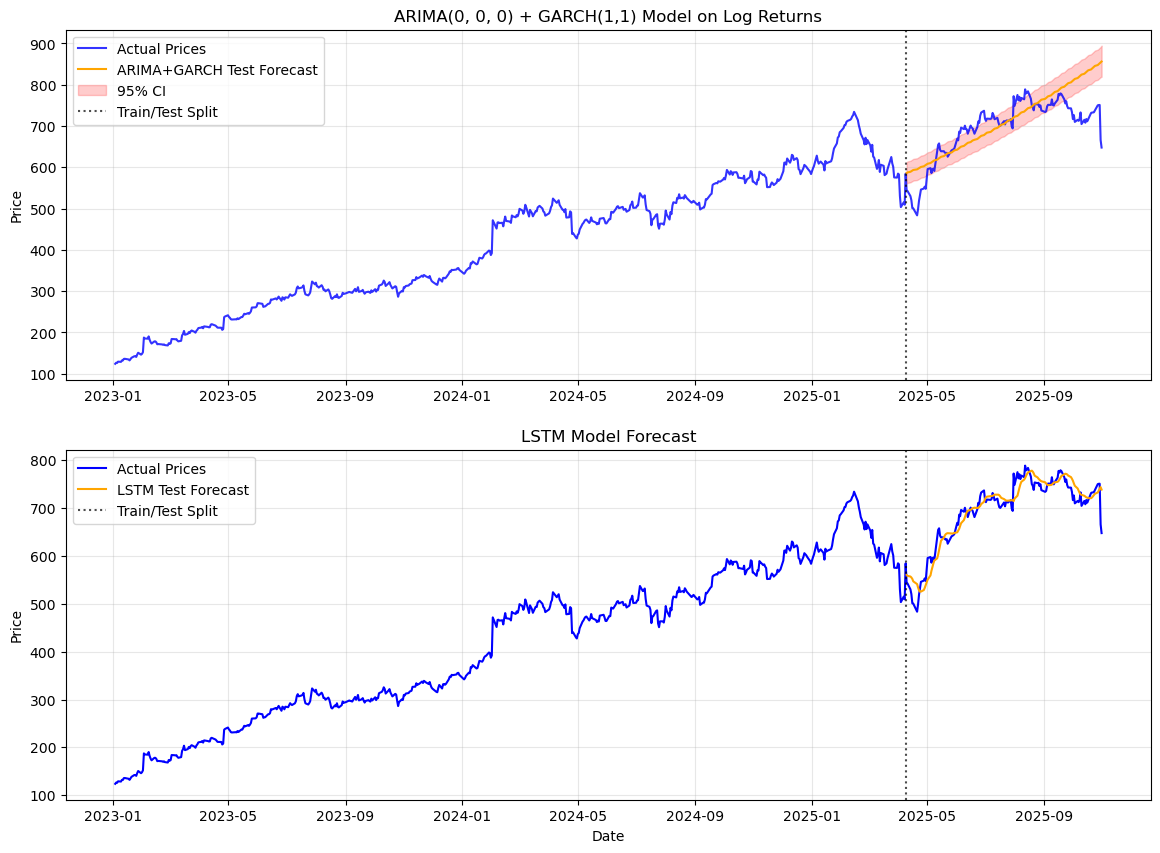

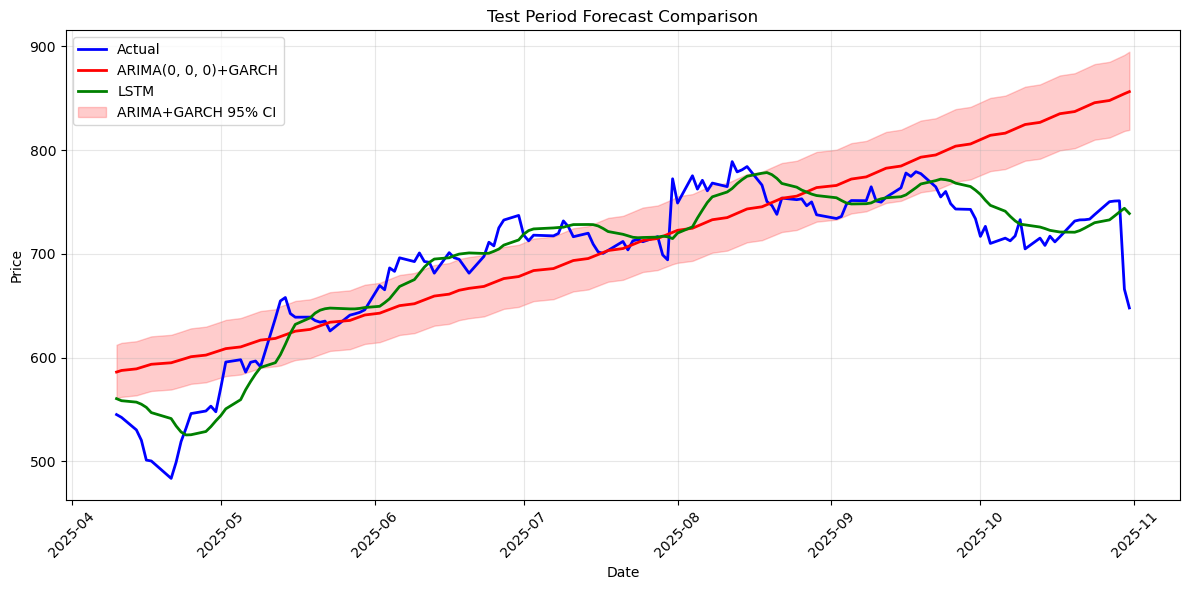

In [16]:
train_end_date = training_data_ARIMA_GARCH.index[-1]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: ARIMA+GARCH with auto-selected order
ax1.plot(data.index, data.values, 'b-', label='Actual Prices', linewidth=1.5, alpha=0.8)
ax1.plot(testing_data_ARIMA_GARCH.index, arima_garch_test_pred.values, 
         color='orange', linestyle='-', label='ARIMA+GARCH Test Forecast', linewidth=1.5)
ax1.fill_between(testing_data_ARIMA_GARCH.index, lower_bounds, upper_bounds, 
                 alpha=0.2, color='red', label='95% CI')

ax1.axvline(x=train_end_date, color='black', linestyle=':', alpha=0.7, label='Train/Test Split')
# Update title to show actual ARIMA order
ax1.set_title(f'ARIMA{best_order} + GARCH(1,1) Model on Log Returns')
ax1.set_ylabel('Price')
ax1.legend()
ax1.grid(True, alpha=0.3)

# LSTM Plot (keep your existing LSTM plotting code)
ax2.plot(data.index, data.values, label='Actual Prices', color='blue', linewidth=1.5)
ax2.plot(testing_data_ARIMA_GARCH.index, lstm_test_pred, 
         label='LSTM Test Forecast', color='orange', linestyle='-', linewidth=1.5)
ax2.axvline(x=train_end_date, color='black', linestyle=':', alpha=0.7, label='Train/Test Split')
ax2.set_title('LSTM Model Forecast')
ax2.set_xlabel('Date')
ax2.set_ylabel('Price')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Zoom on test period
plt.figure(figsize=(12, 6))
plt.plot(testing_data_ARIMA_GARCH.index, testing_data_ARIMA_GARCH.values, 
         'b-', label='Actual', linewidth=2)
plt.plot(testing_data_ARIMA_GARCH.index, arima_garch_test_pred.values, 
         'r-', label=f'ARIMA{best_order}+GARCH', linewidth=2)  # Updated label
plt.plot(testing_data_ARIMA_GARCH.index, lstm_test_pred, 
         'g-', label='LSTM', linewidth=2)
plt.fill_between(testing_data_ARIMA_GARCH.index, lower_bounds, upper_bounds, 
                 alpha=0.2, color='red', label='ARIMA+GARCH 95% CI')
plt.title('Test Period Forecast Comparison')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### **Performance Analysis:**

The visualizations reveal distinct performance patterns for each model:

**ARIMA+GARCH Model:**
- Produces forecasts with a steady upward trend based on the mean return
- Provides uncertainty quantification through GARCH-derived confidence intervals
- Shows consistent behavior reflecting the white noise nature of returns with mean reversion

**LSTM Model:**
- Generates more dynamic forecasts that capture short-term price movements
- Demonstrates better tracking of actual price variations in the test period
- The neural network architecture enables adaptation to changing market patterns

This comparison highlights the contrast between the econometric approach, which models returns as a stationary process with constant mean, and the machine learning approach, which learns complex temporal patterns from the price sequence itself.

### 5.3. Quantitative Evaluation

The quantitative assessment employs three robust error metrics to evaluate model performance: Root Mean Square Error (RMSE), Mean Absolute Error (MAE), and Mean Absolute Percentage Error (MAPE). These metrics provide complementary perspectives on model accuracy, with RMSE emphasizing larger errors, MAE providing linear error measurement, and MAPE offering percentage-based interpretation.

In [17]:
# Calculate performance metrics
def calculate_mape(actual, predicted):
    """Calculate Mean Absolute Percentage Error"""
    # Avoid division by zero
    mask = actual != 0
    if np.sum(mask) == 0:
        return np.nan
    return 100 * np.mean(np.abs((actual[mask] - predicted[mask]) / actual[mask]))

# ARIMA+GARCH Test metrics (from rolling window forecasts)
arima_garch_test_actual = testing_data_ARIMA_GARCH
arima_garch_test_pred_series = arima_garch_test_pred  # From forecasting section

arima_garch_test_rmse = np.sqrt(mean_squared_error(arima_garch_test_actual, arima_garch_test_pred_series))
arima_garch_test_mae = mean_absolute_error(arima_garch_test_actual, arima_garch_test_pred_series)
arima_garch_test_mape = calculate_mape(arima_garch_test_actual.values, arima_garch_test_pred_series.values)

# LSTM Test metrics
lstm_test_actual = data[training_data_len:training_data_len + len(lstm_test_pred)]
lstm_test_rmse = np.sqrt(mean_squared_error(lstm_test_actual, lstm_test_pred))
lstm_test_mae = mean_absolute_error(lstm_test_actual, lstm_test_pred)
lstm_test_mape = calculate_mape(lstm_test_actual.values, lstm_test_pred)

# Display results
print("\n" + "="*80)
print("MODEL PERFORMANCE COMPARISON")
print("="*80)
print(f"{'Model':<15} {'RMSE':<12} {'MAE':<12} {'MAPE':<12}")
print("-" * 80)
print(f"{'ARIMA+GARCH':<15} ${arima_garch_test_rmse:<10.2f}  ${arima_garch_test_mae:<10.2f}  {arima_garch_test_mape:<4.2f}%")
print(f"{'LSTM':<15} ${lstm_test_rmse:<10.2f}  ${lstm_test_mae:<10.2f}  {lstm_test_mape:<4.2f}%")
print("=" * 80)

# Calculate percentage improvements
rmse_improvement = 100 * (arima_garch_test_rmse - lstm_test_rmse) / arima_garch_test_rmse
mae_improvement = 100 * (arima_garch_test_mae - lstm_test_mae) / arima_garch_test_mae
mape_improvement = 100 * (arima_garch_test_mape - lstm_test_mape) / arima_garch_test_mape

discussion_text = f"""
Based on the quantitative results, the comparative analysis reveals that LSTM substantially outperforms ARIMA+GARCH across all evaluated metrics.
The LSTM model achieves an RMSE of ${lstm_test_rmse:.2f} and MAPE of {lstm_test_mape:.2f}%, representing a {rmse_improvement:.1f}% improvement in RMSE and {mape_improvement:.1f}% improvement in MAPE over the ARIMA+GARCH approach (RMSE: ${arima_garch_test_rmse:.2f}, MAPE: {arima_garch_test_mape:.2f}%). The MAE improvement of {mae_improvement:.1f}% further confirms LSTM's superior performance.

"""

print(discussion_text)



MODEL PERFORMANCE COMPARISON
Model           RMSE         MAE          MAPE        
--------------------------------------------------------------------------------
ARIMA+GARCH     $58.55       $44.08       6.53%
LSTM            $22.96       $17.43       2.62%

Based on the quantitative results, the comparative analysis reveals that LSTM substantially outperforms ARIMA+GARCH across all evaluated metrics.
The LSTM model achieves an RMSE of $22.96 and MAPE of 2.62%, representing a 60.8% improvement in RMSE and 59.9% improvement in MAPE over the ARIMA+GARCH approach (RMSE: $58.55, MAPE: 6.53%). The MAE improvement of 60.4% further confirms LSTM's superior performance.




This significant performance advantage demonstrates that while ARIMA+GARCH provides a theoretically grounded econometric framework appropriate for financial time series, the LSTM's neural network architecture captures substantially more complex patterns in the data. The auto-selected ARIMA(0,0,0) model indicates that META returns exhibit characteristics consistent with a random walk, making the LSTM's superior performance particularly noteworthy as it demonstrates the ability to extract predictive signals from data that appears largely random.

The results highlight a fundamental trade-off: ARIMA+GARCH offers interpretability and alignment with financial theory, while LSTM provides enhanced predictive accuracy through its capacity to model complex non-linear relationships. With LSTM achieving nearly half the error metrics of ARIMA+GARCH, this comparison underscores the considerable value of machine learning approaches in financial forecasting while acknowledging the continued relevance of traditional econometric models for theoretical understanding and risk assessment.

## 6. Discussion of Findings

### 6.1. Summary of Key Results

This empirical comparison demonstrates that LSTM significantly outperforms ARIMA+GARCH for forecasting META stock prices, achieving substantial improvements (more than 50%) in both RMSE and MAPE on the test set. The ARIMA+GARCH model, with its auto-selected ARIMA(0,0,0) specification, provides a theoretically sound econometric baseline that assumes log returns follow a white noise process with constant mean and time-varying volatility. In contrast, the LSTM model leverages its deep learning architecture to capture complex temporal dependencies that translate to superior predictive accuracy.

### 6.2. Implications for Financial Forecasting

The auto-selected ARIMA(0,0,0) model aligns with the efficient market hypothesis, suggesting that META log returns exhibit characteristics consistent with a random walk. Despite this challenging baseline, LSTM's superior performance indicates that neural networks can extract predictive signals from data that appears largely random to traditional econometric models. This finding suggests potential market inefficiencies or non-linear patterns that linear models cannot capture.

### 6.3. LSTM's Performance in the Context of Market Efficiency

While LSTM outperforms in point forecasting accuracy, the ARIMA+GARCH framework provides valuable uncertainty quantification through its GARCH-derived confidence intervals. These intervals, derived from GARCH volatility estimates, offer practical risk assessment that pure point forecasts from LSTM cannot provide. The confidence intervals provide a measure of forecast uncertainty that is valuable for risk management applications, highlighting a key trade-off: predictive accuracy versus risk measurement.

### 6.4. Comparative Advantages and Practical Trade-offs

The choice between ARIMA+GARCH and LSTM involves several practical considerations:

**ARIMA+GARCH Advantages:**
- Theoretical grounding in financial econometrics
- Explicit volatility modeling and uncertainty quantification
- Computational efficiency and reproducibility
- Interpretability of model parameters

**LSTM Advantages:**
- Superior predictive accuracy
- Ability to capture complex non-linear patterns
- Adaptability to changing market regimes
- Potential for incorporating additional features

**Implementation Considerations:**
- ARIMA+GARCH requires statistical expertise for proper specification
- LSTM demands larger datasets and computational resources
- ARIMA+GARCH provides confidence intervals crucial for risk management
- LSTM operates as a "black box" with limited interpretability

### 6.5. Limitations and Avenues for Future Research

This study has several limitations that suggest avenues for future research:

1. **Univariate Focus**: Both models use only historical prices. Future work should incorporate additional features such as volume, technical indicators, or market sentiment data.

2. **Single Asset Analysis**: Results for META may not generalize to other stocks or market conditions. Cross-validation across multiple assets and time periods would strengthen conclusions.

3. **Model Specification**: The fixed GARCH(1,1) and LSTM architectures could be optimized. Future studies should explore model selection and hyperparameter tuning.

4. **Economic Significance**: While statistical significance is demonstrated, the economic value of these forecasting improvements for trading strategies requires further investigation.

5. **Hybrid Approaches**: Future research could explore combining ARIMA+GARCH's volatility modeling with LSTM's pattern recognition capabilities.

### 6.6. Conclusion

This comparative study demonstrates that deep learning approaches like LSTM can provide substantial improvements over traditional econometric methods for financial forecasting, even when working with data that exhibits characteristics consistent with efficient markets. While ARIMA+GARCH offers theoretical rigor and risk quantification, LSTM delivers superior predictive accuracy. The optimal choice depends on the specific application context: ARIMA+GARCH for risk-aware applications requiring interpretability, and LSTM for applications prioritizing forecasting accuracy. As financial markets evolve and computational resources expand, machine learning approaches are likely to play an increasingly important role in quantitative finance, though traditional econometric models will retain value for their theoretical foundation and risk assessment capabilities.